# Description

This script imports xlsx files, and do the following things to the data
1. Seperate sheets
2. Select data in proper time range
3. Calculate max value of each set of data, filter out those do not reach threshold
4. Calculate baseline using certain data, calculate the criterion 
5. Find the first time point each set of data reach the criterion
6. Plot the average time_point of each group of data with sem as error bar

In [1]:
import numpy as np
import pandas as pd
import xlrd
import math

In [2]:
datapath
data = pd.ExcelFile(datapath)

In [3]:
sheets = data.sheet_names
threshold = 1.1
end_time = 30

In [4]:
l = len(sheets)
data_dict = {}
sem = {}
avg = {}

for i in xrange(l):
    
    tmp = data.parse(sheets[i])
    col = tmp.columns.values
    
    max_after = tmp.loc[(tmp[col[0]] >0) & (tmp[col[0]] <= end_time)].max()
    max_after = max_after.loc[max_after > threshold].to_frame().transpose()
    max_after[col[0]] = "max"
    
    valid_cols = max_after.columns.values

    avg4 = tmp.loc[tmp[valid_cols[0]] <= 0, tmp.columns.isin(valid_cols)]\
            .mean().to_frame().transpose()
    avg4[col[0]] = "avg"
    
    tmp = tmp.loc[tmp[col[0]] <= end_time, tmp.columns.isin(valid_cols)]\
            .append(avg4, ignore_index = True)\
            .append(max_after, ignore_index = True)

    para = max_after.append(avg4, ignore_index = True)
    para = para.append((para.ix[0, 1:] - para.ix[1, 1:]) / 2 + para.ix[1, 1:], ignore_index = True)
    para.ix[2, 0] = "threshold"
    
    tmp = tmp.append(para, ignore_index = True)
    
    time_point = {}
    for column in valid_cols[1:]:
        temp = tmp.ix[:, [valid_cols[0], column]]
        value = temp.iloc[-1, 1]
        time_point[column] = temp.loc[(temp[valid_cols[0]] > 0) & (temp[column] >= value)].iloc[0, 0]
    
    select_time = pd.DataFrame([time_point])
    tmp = tmp.append(select_time, ignore_index = True)
    tmp.iloc[-1, 0] = "first_time_point"
    


    data_dict[sheets[i]] = tmp
    
    std = select_time.std(axis = 1).values[0]
    print std
    sem[sheets[i]] = std / math.sqrt(select_time.count(axis = 1).values[0])
    avg[sheets[i]] = select_time.mean(axis = 1).values[0]
    
    filename = sheets[i] + '_time_point.csv'
    select_time.to_csv(filename, sep='\t')
    
    filename2 = sheets[i] + '_filtered_data.csv'
    
    data_dict[sheets[i]].to_csv(filename2, sep='\t')

6.75225452545
3.32932659624
4.97459609766
4.79459020544


In [5]:
sem

{u'J.Cam_ERK BS_LckKR': 0.90609238014704907,
 u'J.Cam_ERK_BS': 0.94550475342767326,
 u'J.Cam_ERK_BS_LckWT': 0.70981481529965995,
 u'J.Cam_ERK_BS_LckYF': 0.68985235787814148}

In [6]:
avg

{u'J.Cam_ERK BS_LckKR': 12.107142857142858,
 u'J.Cam_ERK_BS': 12.352941176470589,
 u'J.Cam_ERK_BS_LckWT': 6.6818181818181817,
 u'J.Cam_ERK_BS_LckYF': 6.8076923076923075}

In [7]:
import numpy as np
import pylab as pl
%matplotlib inline
import matplotlib

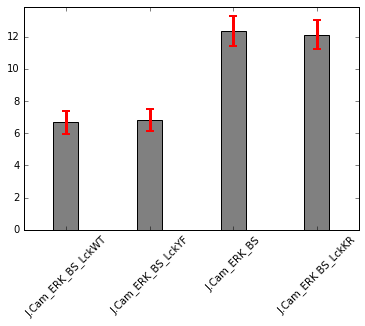

In [8]:
X = np.arange(len(avg))
pl.bar(X, avg.values(), align='center', width=0.3, yerr=sem.values(),\
        color='grey',\
        error_kw=dict(ecolor='red', lw=3, capsize=4, capthick=2))
pl.xticks(X, avg.keys())
ymax = max(avg.values()) + 1.5
pl.ylim(0, ymax)
pl.xticks(rotation=45)
pl.show()